## Long short-term memory

*Эпоха* - это **весь** датасет обученный один раз: forwarding и back propagation. Количество эпох зависит от данных, т.е. нельзя в точности сказать что для такой-то задачи нужно вот столько-то эпох. Слишком много эпох вызовет переобучение, слишком мало может вызвать недообучение.

*Батч* - это часть датасета, т.е. весь датасет можно разбить на батчи какого-то размера. Количество батчей равняется количеству итераций в эпохе, и если посмотреть с другой стороны, то количество итерации - это количество батчей для обучения одной эпохи.

In [129]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from metrics import mar, far, f1_score

In [130]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Dense, LSTM, RepeatVector

### Process data

In [131]:
df = pd.read_csv("./data/valve1/0.csv", 
                 sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)
train_size = 400
df.head()


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


In [132]:

SS = StandardScaler()
x_train = np.array(SS.fit_transform(df[:train_size].drop(['anomaly','changepoint'], axis=1)))
y = df.anomaly

In [133]:
TIME_STEPS = 20

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(x_train)
print("Training input shape: ", x_train.shape)

Training input shape:  (381, 20, 8)


### Make model

In [134]:
n_features = x_train.shape[2]
n_features

8

In [135]:
model = Sequential()

model.add(LSTM(units=128, activation='relu', return_sequences=True, 
               input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(LSTM(units=64, activation='relu', return_sequences=False))
# Encoding is done
model.add(RepeatVector(TIME_STEPS))

model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer='adam', loss='mse')

### Fitting

In [136]:
import keras

In [137]:
history = model.fit(x_train, x_train, epochs=1, batch_size=5)

77/77 [==============================] - 8s 43ms/step - loss: 0.8845


In [138]:
Q = 0.99

In [139]:
health_r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_train) - x_train), axis=1), axis=1))
UCL = health_r.quantile(Q)

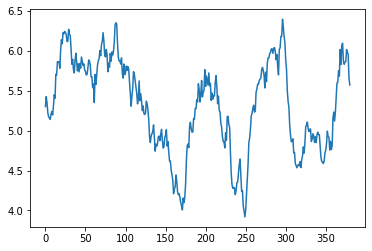

In [140]:
plt.plot(health_r)

### Make predictions

In [141]:
y_test = df["anomaly"].astype(int)
df.drop(["anomaly", "changepoint"], inplace=True, axis=1)

x_test = np.array(SS.transform(df))

In [142]:
x_test = create_sequences(x_test)
print("Training input shape: ", x_test.shape)

Training input shape:  (1128, 20, 8)


In [143]:
r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))

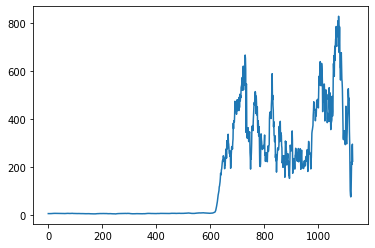

In [144]:
plt.plot(r)

In [145]:
anomalous_data = r > (3/2 * UCL)
anomalous_data_indices = [] 
for data_idx in range(TIME_STEPS - 1, len(x_test) - TIME_STEPS + 1):
    if np.all(anomalous_data[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


In [146]:
TIME_STEPS

20

In [147]:
prediction = pd.Series(data=0, index=df.index)
prediction.iloc[anomalous_data_indices] = 1

In [148]:
b = pd.DataFrame({"pred":prediction, "test":y_test})
len(b[b.test > b.pred]), len(b[b.test < b.pred])

(59, 135)

### Vizualization

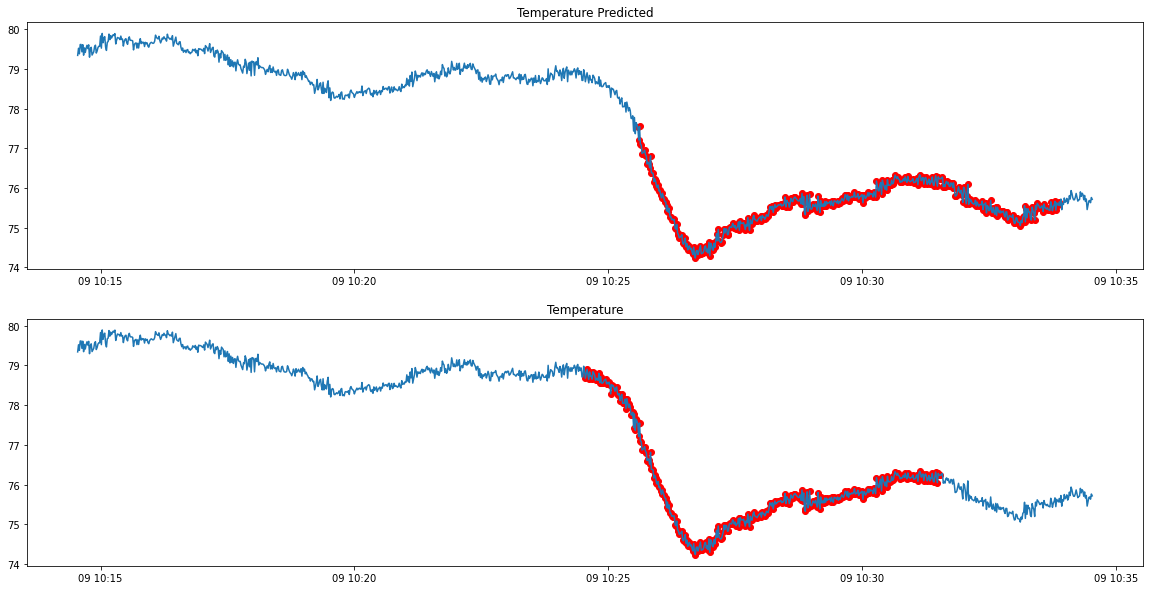

In [149]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

Проблема: Предсказание аномалий начинается примерно на 80 тиков позже, а заканчивается на 135 тиков позже

<img src="img/shift.jpg" width=800 height=600 />

In [150]:
print(f"""F1 = {f1_score(y_test, prediction)}
FAR = {far(y_test, prediction)}
MAR = {mar(y_test, prediction)}""")

F1 = 0.7790432801822323
FAR = 0.18096514745308312
MAR = 0.14713216957605985
